In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def func(i):
    return 4*i**3 + 3*i**2 + 2*i + 6

In [26]:
func(3)

147

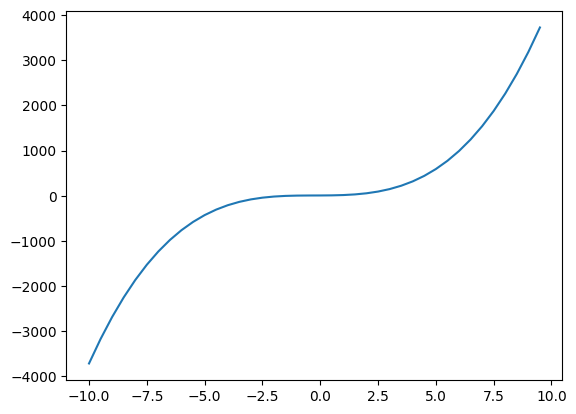

In [27]:
x_s = np.arange(-10, 10, 0.5)
y_s = func(x_s)
plt.plot(x_s, y_s)

In [28]:
x = 7
h = 0.0000000000001
(func(x + h) - func(x)) / h

634.3725544866174

In [29]:
a = 1
b = 2
c = 3
d = a*b / c
print(d)

0.6666666666666666


In [30]:
h = 0.001
a = 10
b = 5
c = 20
d1 = a*b / c
a += h
d2 = a*b / c
print((d2 - d1)/ h)

0.24999999999986144


In [32]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.prev = set(_children)
        self.op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None  # function to compute gradient

    def __repr__(self):
        return f"Value(data={self.data})"

    # Negation
    def __neg__(self):
        return self * -1

    # Addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    # Multiplication
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    # Reverse multiplication
    def __rmul__(self, other):
        return self * other

    # Subtraction
    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        return self.pow(other)

    # Division
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * (other ** -1)

    # Power
    def pow(self, other):
        assert isinstance(other, (float, int)), "only supporting int/float powers"
        out = Value(self.data ** other, (self,), f"pow{other}")
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    # Exponential
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    # Tanh
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    # Backpropagation
    def backward(self):
        topo = []
        visited = set()

        def buildTopo(node):
            if node not in visited:
                visited.add(node)
                for child in node.prev:
                    buildTopo(child)
                topo.append(node)

        buildTopo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()


In [33]:
a = Value(2)
b = 4
a / b

Value(data=0.5)

In [34]:
a = Value(3, label = 'a')
b = Value(4.0, label = 'b')
c = Value(4, label = 'c')
f = Value(6, label = 'f')
#a.__add__(b)
#a.__mul__(b)
p = a*b
p.label = 'p'
d = p + c
d.label = 'd'
e = f * d
e.label = e
#a + b
a

Value(data=3)

In [35]:
d.prev

{Value(data=12.0), Value(data=4)}

In [36]:
d.op

'+'

In [41]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            # changed _prev → prev to match your Value class
            for child in v.prev:  
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ data %.4f }" % (n.data,), shape='record')

        if n.op:  # changed _op → op (your class uses self.op)
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n.op, label=n.op)
            # and connect this op node to it
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot

In [42]:
e.grad = 1
d.grad = 6
f.grad = 16
c.grad = 6
p.grad = 6
a.grad = 24
b.grad = 18

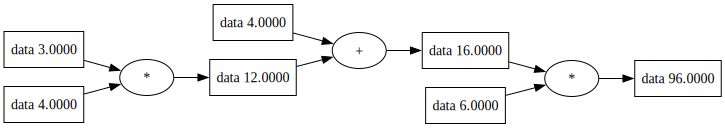

In [43]:
draw_dot(e)

In [44]:
a.data += a.grad * 0.001
b.data += b.grad * 0.001
c.data += c.grad * 0.001
f.data += f.grad * 0.001

p = a * b
d = p + c
e = f * d
print(e)

Value(data=97.19709491200001)


In [45]:
def part_diff_finder():
    h = 0.001
    a = Value(3, label = 'a')
    b = Value(4.0, label = 'b')
    c = Value(4, label = 'c')
    f = Value(6, label = 'f')
    p = a*b
    d = p + c
    e = f * d
    L1 = e

    a = Value(3 + h, label = 'a')
    b = Value(4.0, label = 'b')
    c = Value(4, label = 'c')
    f = Value(6, label = 'f')
    p = a*b
    d = p + c
    e = f * d
    L2 = e
    #by incrementing variables by h we can get gradient of l1 corresponding to different variable

    diff = (l2 - l1) / h



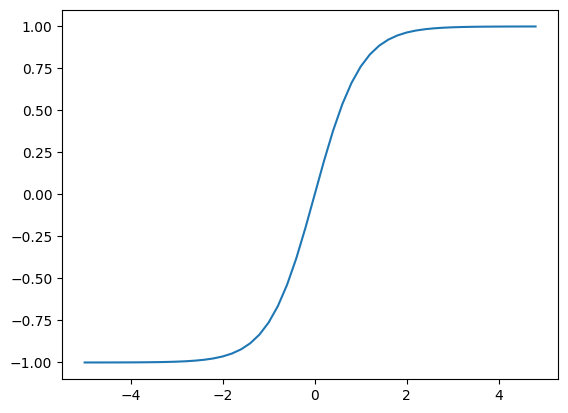

In [46]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))

In [47]:

w1 = Value(2, label = 'w1')
w2 = Value(0, label = 'w2')
x1 = Value(-3, label = 'x1')
x2 = Value(1, label = 'x2')

w1x1 = w1*x1; w1x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2; w2x2.label = 'w2x2'

b = Value(5, label = 'b')
w1x1w2x2 = w1x1 + w2x2
n = w1x1w2x2 + b
n.label = 'n'
w1x1w2x2.label = 'w1x1w2x2'
temp = 2*n.exp()
o = (temp - 1)/(temp + 1)
o.label = 'o'

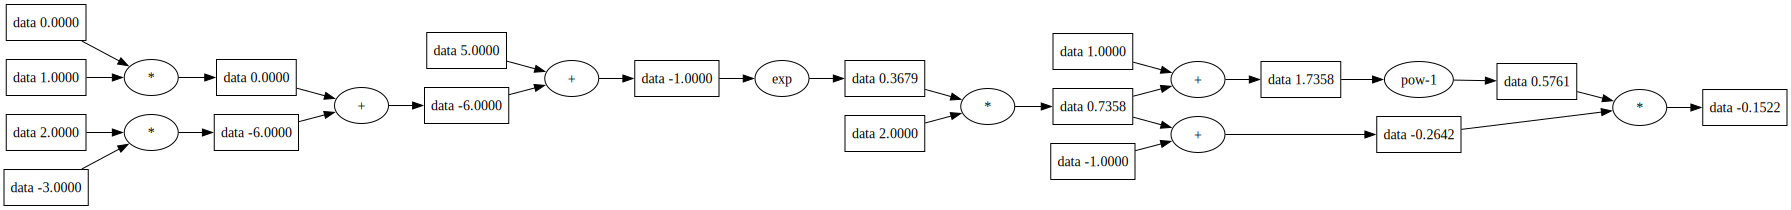

In [49]:
draw_dot(o)

In [50]:
o.grad = 1
o._backward()
n._backward()
w1x1w2x2._backward()
w2x2._backward()
w1x1._backward()

In [51]:
o.backward()

In [52]:
w1.grad = -1.26
x1.grad = 0.84
w2.grad = 0.42
x2.grad = 0

In [53]:
w1x1.grad = 0.42
w2x2.grad = 0.42

In [54]:
b.grad = 0.42
w1x1w2x2.grad = 0.42

In [55]:
n.grad = 0.42

In [56]:
o.grad = 1

In [57]:
import torch

In [58]:
x1 = torch.tensor([2.0]).double()        ;x1.requires_grad = True
x2 = torch.tensor([0.0]).double()        ;x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()       ;w1.requires_grad = True
w2 = torch.tensor([1.0]).double()        ;w2.requires_grad = True
b = torch.tensor([6.8813735870]).double();b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('___')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
___
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [59]:
o.data.item()

0.7071066904050358

In [60]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        h = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = h.tanh()
        return out
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nout))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
#n = Neuron(2)
#l = Layer(2, 3)
x = [2, 3, -1]
n = MLP(3,[4,4,1])
n(x)
#n(x)

[Value(data=0.08665502147681675)]

In [62]:
#draw_dot(n(x))

In [65]:
#xs = [
    #[2, 3, -1],
    #[3, -1, 0.5],
    #[0.5, 1, 1],
    #[1, 1, -1],
#]
#ys = [1, -1, -1, 1]